In [13]:
!ls "sample_data"

anscombe.json		      mmmm.mov		     README.md
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


In [3]:
!python -m pip install librosa

In [4]:
!pip install pydub

In [5]:
from pydub import AudioSegment
from pydub.utils import mediainfo
import scipy
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython import display
import IPython.display as ipd

# Reading file and preprocessing


In [28]:
# reading file from folder

src = "sample_data/mmmm.mov"

audio = AudioSegment.from_file(src)

audio_data = np.array(audio.get_array_of_samples())

if audio.channels == 2:
    audio_data = audio_data.reshape((-1, 2))
    audio_data = audio_data.mean(axis=1)

y = audio_data.astype(np.float32) / (2**15)
sr = audio.frame_rate

if sr != 22050:
    y = librosa.resample(y, orig_sr=sr, target_sr=22050)
    sr = 22050

print(f"Audio loaded successfully, sample rate: {sr} duration: {len(y)/sr:.2f} seconds”")

Audio loaded successfully, sample rate: 22050 duration: 4.13 seconds”


In [9]:
ipd.Audio(y, rate=sr)

In [11]:
# y is the audio sample

# sr is the sampling rate (no: samples / second)

y.shape, sr

((91136,), 22050)

In [16]:
# getting audio file info

info = mediainfo(src)
duration = float(info['duration']) # in seconds

def get_info():
    file_size_kb = float(info['size']) / 1024
    file_size_mb = file_size_kb / 1024

    # Choose appropriate unit based on size
    if file_size_mb >= 1:
        size_str = f"{file_size_mb:.2f} MB"
    else:
        size_str = f"{file_size_kb:.2f} KB"

    msg = f"""  file name          : {info['filename']}
  file size          : {size_str}
  audio duration     : {info['duration']} seconds
  sample rate        : {info['sample_rate']} Hz
  audio channels     : {info['channels']}"""

    print(msg)

In [17]:
get_info()

  file name          : sample_data/mmmm.mov
  file size          : 38.39 KB
  audio duration     : 4.118000 seconds
  sample rate        : 22050 Hz
  audio channels     : 1


In [19]:
# normalizing

samples = y/y.max()

In [20]:

# create x-axis timeline for refference in plot

timeline = np.linspace(0, duration, len(y))

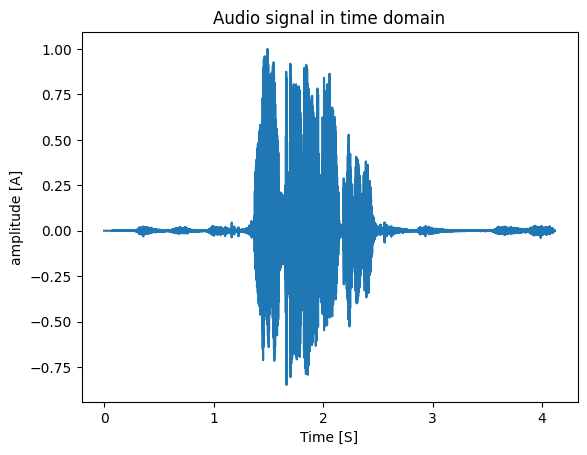

In [21]:
# plotting audio sample

plt.plot(timeline, samples)
plt.title("Audio signal in time domain")
plt.xlabel("Time [S]")
plt.ylabel("amplitude [A]")
plt.show()

# VAD - Voice Activity Detection

In [29]:
# initializing variables

weight = 0.1 # weight or a adjustable parameter
v_window = int(0.01*len(samples)) # window size = here we take 1% of sample size.
vad_T = np.mean(samples**2) * weight
vad_T, v_window

(np.float32(0.0016670186), 911)

In [30]:
# voice activity detection

vad = np.zeros(shape=samples.shape)
ref_idx = []
for s_set in range(0, len(samples)-v_window, v_window):
      win_samples = samples[s_set:(s_set + v_window)]
      s_T = np.mean(win_samples**2)
      if s_T > vad_T:
        vad[s_set:(s_set + v_window)] = 1.0
        ref_idx.append(s_set)
      else:
        vad[s_set:(s_set + v_window)] = 0.0

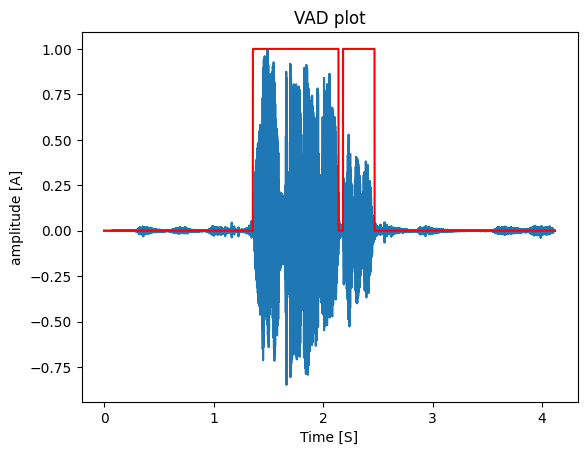

In [31]:
# plotting audio samples

plt.plot(timeline, samples)
plt.plot(timeline, vad, color='red')
plt.title("VAD plot")
plt.xlabel("Time [S]")
plt.ylabel("amplitude [A]")
plt.show()

In [32]:
# cropping audio only across VAD timeline
new_samples = samples[min(ref_idx) : max(ref_idx)]
new_timeline = np.linspace(0, len(new_samples)/sr, len(new_samples))

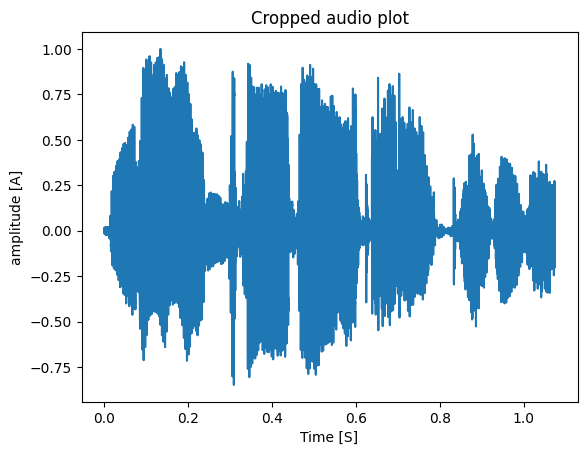

In [33]:
# plotting audio samples

plt.plot(new_timeline, new_samples)
plt.title("Cropped audio plot")
plt.xlabel("Time [S]")
plt.ylabel("amplitude [A]")
plt.show()

In [34]:
ipd.Audio(new_samples, rate=sr)

# pre-emphasis

In [35]:
# pre-emphasising audio signal

pre_emphasis = 0.97
emphasized_signal = np.append(new_samples[0], new_samples[1:] - pre_emphasis * new_samples[:-1])
emphasized_signal.shape

(23686,)

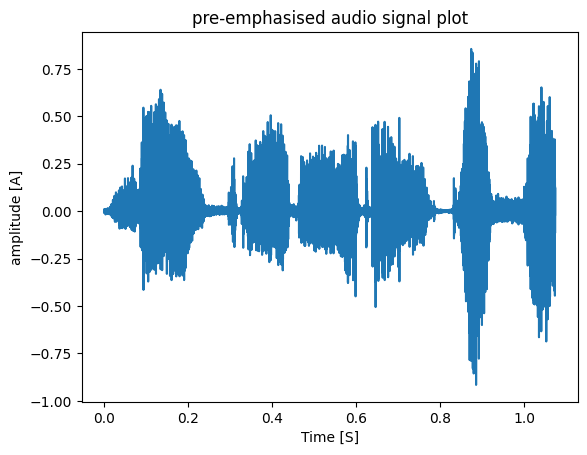

In [36]:
plt.plot(new_timeline, emphasized_signal)
plt.title("pre-emphasised audio signal plot")
plt.xlabel("Time [S]")
plt.ylabel("amplitude [A]")
plt.show()

In [37]:
ipd.Audio(emphasized_signal, rate=sr)

# fast fourier transform (FFT) - (time domain to frequency domain)

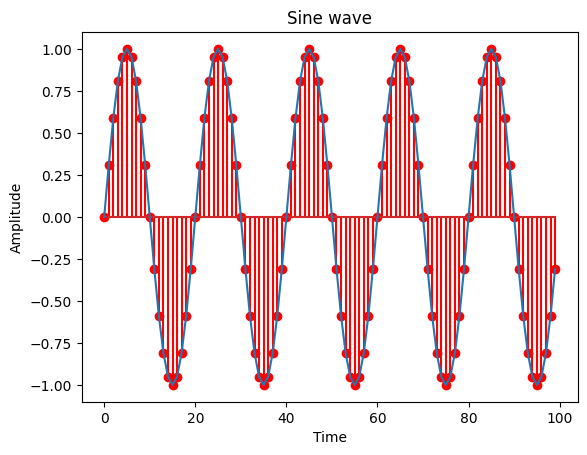

In [38]:
# basic sine wave

f = 5 #frequency
s = 100 #samples

x = np.arange(s)
y = np.sin(2*np.pi*f*(x/s))

plt.figure()
plt.stem(x, y,'r')
plt.plot(x, y)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Sine wave")
plt.show()

In [41]:
def plot_fft(signal, sr):
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sr)
    plt.plot(freq, np.abs(fft_spectrum), c='b')
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.title("FFT plot")
    plt.grid()
    plt.show()


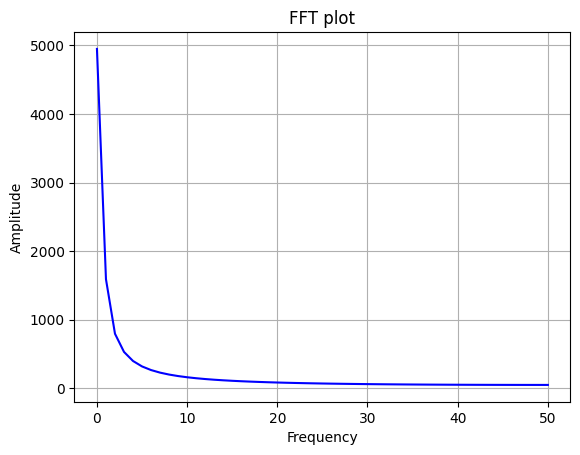

In [42]:
plot_fft(x, s)

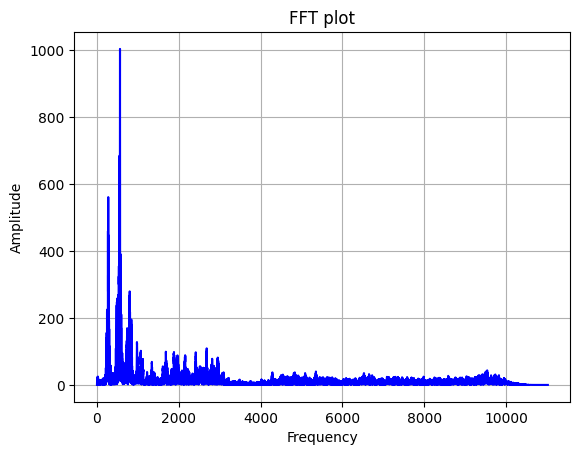

In [43]:
plot_fft(samples, sr)

# Sampling or Framing Audio signal

In [44]:
f_d = 0.0065
n_f = len(samples)
f_size = int(np.round(n_f * f_d))
print("frame duration: ", f_d, ", number of frames: ", n_f, ", frame size: ", f_size)

frame duration:  0.0065 , number of frames:  91136 , frame size:  592


In [45]:
frames = []

for i in range(0, (n_f-f_size), f_size):
  frame = samples[i:i+f_size]
  frames.append(frame)

frames = np.asarray(frames)
frames.shape

(153, 592)

In [46]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_xlim(0,f_size)
    ax.set_ylim(-1,1)
    line, = ax.plot(frames[i, :], color = 'blue', lw=1)
    return line,

ani = FuncAnimation(fig, animate, interval=50, blit=True, repeat=True, frames=150)
# SAVE
ani.save("frame.gif", dpi=300, writer=PillowWriter(fps=20))

# live plot
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

# Hann window function

In [48]:
def hanning(M):
    w = 0.54 - 0.46*np.cos(2*np.pi*np.arange(1, M+1)/(M-1))
    return w

In [49]:
wf = hanning(frames.shape[1])
wf.shape

(592,)

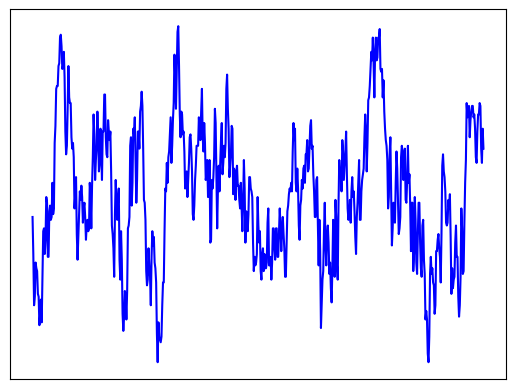

In [50]:
plt.plot(frames[126], c='b')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

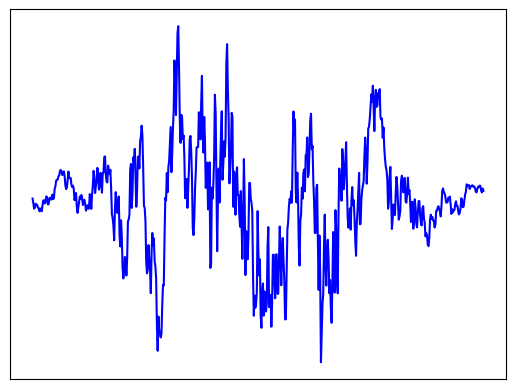

In [51]:
# plot example
fw = np.multiply(frames[126], wf)

plt.plot(fw, c='b')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

In [52]:
# appliying hanning to all frames
frame_W = []
for f in frames:
    frame_W.append(np.multiply(wf, f))
frame_W = np.array(frame_W)
frame_W.shape

(153, 592)

In [54]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_xlim(0,f_size)
    ax.set_ylim(-1,1)
    line, = ax.plot(frame_W[i, :], color = 'blue', lw=1)
    return line,

ani = FuncAnimation(fig, animate, interval=50, blit=True, repeat=True, frames=150)
ani.save("windows.gif", dpi=300, writer=PillowWriter(fps=20))

# live plot
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()


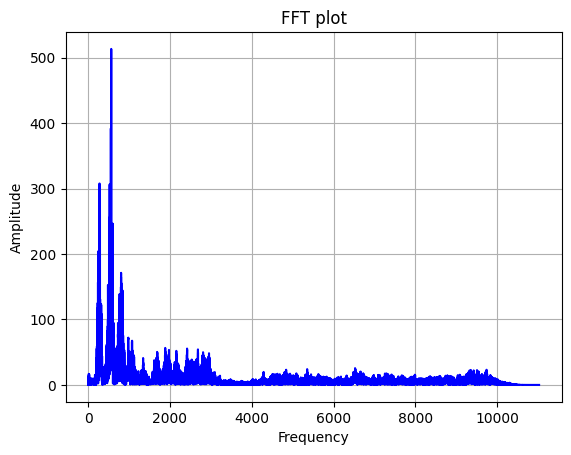

In [55]:
plot_fft(frame_W.ravel(), sr)

# spectrum plot

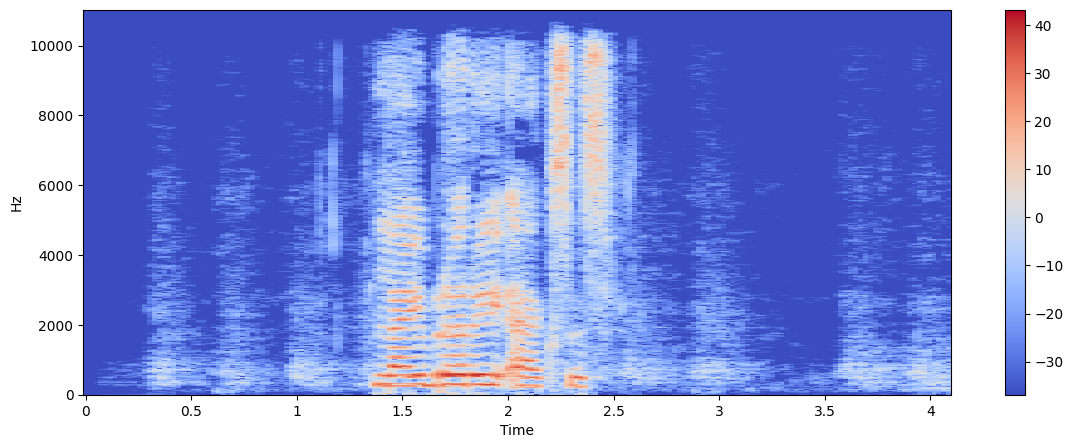

In [56]:
#display Spectrogram
X = librosa.stft(frame_W.ravel())
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
#If to pring log of frequencies
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

# MFCC - Mel-Frequency Cepstral Coefficients

(20, 177)


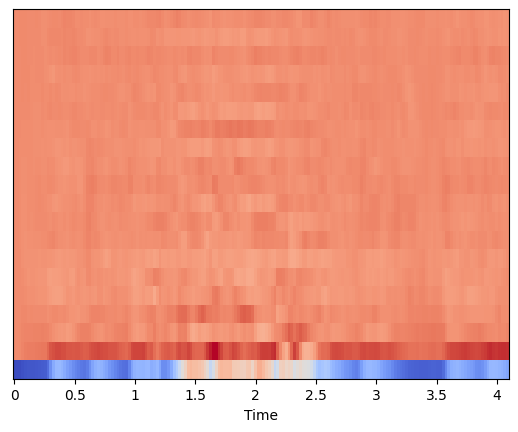

In [58]:
mfccs = librosa.feature.mfcc(y=frame_W.ravel(), sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')


In [59]:
wav = librosa.feature.inverse.mfcc_to_audio(mfccs)

ipd.Audio(wav, rate=sr)